So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before
Vanilla Gumbel

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025238
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364944
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.814362
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.379112
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789692
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.276009
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.740120
====> Epoch: 1 Average loss: 40.2651
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.672573
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.857533
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.325977
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.101463
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.596703
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.989117
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.360310
====> Epoch: 2 Average loss: 36.4149
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.523701
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.206936
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.856945
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.793369
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.988956
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.013247
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.270163
====> Epoch: 22 Average loss: 31.2534
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.400995
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.041733
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.345234
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.320532
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.026028
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.138870
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.540070
====> Epoch: 23 Average loss: 31.1998
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.346783
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.366404
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.085634
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.071608
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.239252
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.930275
Train Epoch: 24 [7680/8000 (96%)]	Loss: 30.941076
====> Epoch: 24 Average loss: 31.1411
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.086084
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.14980

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.670044
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.412287
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.284142
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.688267
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.450047
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.535494
====> Epoch: 44 Average loss: 30.5022
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.533203
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.846596
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.508860
Train Epoch: 45 [3840/8000 (48%)]	Loss: 29.904802
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.310843
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.303701
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.523859
====> Epoch: 45 Average loss: 30.4841
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.400795
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.438272
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.436558
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.414251
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.590418
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.314861
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.275429
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.515646
====> Epoch: 65 Average loss: 30.2654
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.269190
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.405798
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.376183
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.321278
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.236647
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.661760
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.284760
====> Epoch: 66 Average loss: 30.2637
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.550797
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.160597
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.037903
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.047459
Train Epoch: 67 [5120/8000 (64%)]	Loss: 29.959616
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.219284
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.353281
====> Epoch: 67 Average loss: 30.2571
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.20444

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178322
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.091436
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.255022
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.174248
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.241972
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.892473
====> Epoch: 87 Average loss: 30.1181
Train Epoch: 88 [0/8000 (0%)]	Loss: 29.949902
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.106182
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.103258
Train Epoch: 88 [3840/8000 (48%)]	Loss: 29.951073
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.088888
Train Epoch: 88 [6400/8000 (80%)]	Loss: 29.955593
Train Epoch: 88 [7680/8000 (96%)]	Loss: 29.905472
====> Epoch: 88 Average loss: 30.1153
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.026413
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.342913
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.477049
Train Epoch: 89 [3840/8000 (48%)]	Loss: 29.976637
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.036428
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.187504
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.084991
Train Epoch: 108 [6400/8000 (80%)]	Loss: 29.825407
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.185699
====> Epoch: 108 Average loss: 30.0199
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.047487
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.071058
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.151487
Train Epoch: 109 [3840/8000 (48%)]	Loss: 29.893038
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.048811
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.199945
Train Epoch: 109 [7680/8000 (96%)]	Loss: 29.811132
====> Epoch: 109 Average loss: 30.0074
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.155910
Train Epoch: 110 [1280/8000 (16%)]	Loss: 29.979328
Train Epoch: 110 [2560/8000 (32%)]	Loss: 29.907679
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.225660
Train Epoch: 110 [5120/8000 (64%)]	Loss: 29.976118
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.185572
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.027384
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 29.985014
Train Epoch: 129 [5120/8000 (64%)]	Loss: 29.919464
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.219847
Train Epoch: 129 [7680/8000 (96%)]	Loss: 29.820976
====> Epoch: 129 Average loss: 29.9723
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.122189
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.201637
Train Epoch: 130 [2560/8000 (32%)]	Loss: 29.909433
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.099302
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.374634
Train Epoch: 130 [6400/8000 (80%)]	Loss: 29.855406
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.114468
====> Epoch: 130 Average loss: 29.9691
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.045776
Train Epoch: 131 [1280/8000 (16%)]	Loss: 29.958166
Train Epoch: 131 [2560/8000 (32%)]	Loss: 29.941027
Train Epoch: 131 [3840/8000 (48%)]	Loss: 29.994801
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.670864
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.106087
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091990
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.749752
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.954885
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.014194
Train Epoch: 150 [7680/8000 (96%)]	Loss: 29.903946
====> Epoch: 150 Average loss: 29.9383
Train Epoch: 151 [0/8000 (0%)]	Loss: 29.989189
Train Epoch: 151 [1280/8000 (16%)]	Loss: 29.882895
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.154171
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.058058
Train Epoch: 151 [5120/8000 (64%)]	Loss: 29.770472
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.269991
Train Epoch: 151 [7680/8000 (96%)]	Loss: 29.704365
====> Epoch: 151 Average loss: 29.9426
Train Epoch: 152 [0/8000 (0%)]	Loss: 29.933056
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.089949
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.051254
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.807831
Train Epoch: 152 [5120/8000 (64%)]	Loss: 29.812853
Train Epoch: 152 [6400/8000 (80%)]	Loss: 29.733080
Train Epoch: 152 [7680/8000 (96%)]	Loss: 29.984697
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 29.825205
Train Epoch: 171 [5120/8000 (64%)]	Loss: 29.897509
Train Epoch: 171 [6400/8000 (80%)]	Loss: 29.795473
Train Epoch: 171 [7680/8000 (96%)]	Loss: 29.633804
====> Epoch: 171 Average loss: 29.9267
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.154598
Train Epoch: 172 [1280/8000 (16%)]	Loss: 29.911493
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.012550
Train Epoch: 172 [3840/8000 (48%)]	Loss: 29.933237
Train Epoch: 172 [5120/8000 (64%)]	Loss: 29.937500
Train Epoch: 172 [6400/8000 (80%)]	Loss: 29.816090
Train Epoch: 172 [7680/8000 (96%)]	Loss: 29.972908
====> Epoch: 172 Average loss: 29.9230
Train Epoch: 173 [0/8000 (0%)]	Loss: 29.951574
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.172197
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.894226
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.058176
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.124512
Train Epoch: 173 [6400/8000 (80%)]	Loss: 29.841183
Train Epoch: 173 [7680/8000 (96%)]	Loss: 29.712990
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.222816
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.060699
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.104168
Train Epoch: 192 [7680/8000 (96%)]	Loss: 29.902025
====> Epoch: 192 Average loss: 29.9089
Train Epoch: 193 [0/8000 (0%)]	Loss: 29.930532
Train Epoch: 193 [1280/8000 (16%)]	Loss: 29.928764
Train Epoch: 193 [2560/8000 (32%)]	Loss: 29.963558
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.271313
Train Epoch: 193 [5120/8000 (64%)]	Loss: 29.973206
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.941650
Train Epoch: 193 [7680/8000 (96%)]	Loss: 29.890982
====> Epoch: 193 Average loss: 29.9097
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.111902
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.820795
Train Epoch: 194 [2560/8000 (32%)]	Loss: 29.893639
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.748861
Train Epoch: 194 [5120/8000 (64%)]	Loss: 29.962934
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.054029
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.138664
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.119467
Train Epoch: 213 [5120/8000 (64%)]	Loss: 29.941584
Train Epoch: 213 [6400/8000 (80%)]	Loss: 29.797318
Train Epoch: 213 [7680/8000 (96%)]	Loss: 29.949215
====> Epoch: 213 Average loss: 29.8991
Train Epoch: 214 [0/8000 (0%)]	Loss: 29.839544
Train Epoch: 214 [1280/8000 (16%)]	Loss: 29.883739
Train Epoch: 214 [2560/8000 (32%)]	Loss: 29.887419
Train Epoch: 214 [3840/8000 (48%)]	Loss: 29.690292
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.246571
Train Epoch: 214 [6400/8000 (80%)]	Loss: 29.978983
Train Epoch: 214 [7680/8000 (96%)]	Loss: 29.981712
====> Epoch: 214 Average loss: 29.9021
Train Epoch: 215 [0/8000 (0%)]	Loss: 29.795774
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.158306
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.867483
Train Epoch: 215 [3840/8000 (48%)]	Loss: 29.992905
Train Epoch: 215 [5120/8000 (64%)]	Loss: 29.758713
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.128817
Train Epoch: 215 [7680/8000 (96%)]	Loss: 29.955023
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.038889
Train Epoch: 234 [5120/8000 (64%)]	Loss: 29.957014
Train Epoch: 234 [6400/8000 (80%)]	Loss: 29.933414
Train Epoch: 234 [7680/8000 (96%)]	Loss: 29.695461
====> Epoch: 234 Average loss: 29.8886
Train Epoch: 235 [0/8000 (0%)]	Loss: 29.780043
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.145016
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.855495
Train Epoch: 235 [3840/8000 (48%)]	Loss: 29.794701
Train Epoch: 235 [5120/8000 (64%)]	Loss: 29.772831
Train Epoch: 235 [6400/8000 (80%)]	Loss: 29.978886
Train Epoch: 235 [7680/8000 (96%)]	Loss: 29.753181
====> Epoch: 235 Average loss: 29.8867
Train Epoch: 236 [0/8000 (0%)]	Loss: 29.773815
Train Epoch: 236 [1280/8000 (16%)]	Loss: 29.933281
Train Epoch: 236 [2560/8000 (32%)]	Loss: 29.645767
Train Epoch: 236 [3840/8000 (48%)]	Loss: 29.926254
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.930956
Train Epoch: 236 [6400/8000 (80%)]	Loss: 29.873896
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.033524
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 29.914280
Train Epoch: 255 [5120/8000 (64%)]	Loss: 29.604420
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.064692
Train Epoch: 255 [7680/8000 (96%)]	Loss: 29.801399
====> Epoch: 255 Average loss: 29.8879
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.018766
Train Epoch: 256 [1280/8000 (16%)]	Loss: 29.783800
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.791483
Train Epoch: 256 [3840/8000 (48%)]	Loss: 29.889681
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.727346
Train Epoch: 256 [6400/8000 (80%)]	Loss: 29.899672
Train Epoch: 256 [7680/8000 (96%)]	Loss: 29.867802
====> Epoch: 256 Average loss: 29.8831
Train Epoch: 257 [0/8000 (0%)]	Loss: 29.792427
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.205387
Train Epoch: 257 [2560/8000 (32%)]	Loss: 29.972410
Train Epoch: 257 [3840/8000 (48%)]	Loss: 29.745226
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.816378
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.031929
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.761208
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 29.628841
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.032913
Train Epoch: 276 [6400/8000 (80%)]	Loss: 29.950617
Train Epoch: 276 [7680/8000 (96%)]	Loss: 29.897568
====> Epoch: 276 Average loss: 29.8897
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.019409
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.637428
Train Epoch: 277 [2560/8000 (32%)]	Loss: 29.856844
Train Epoch: 277 [3840/8000 (48%)]	Loss: 29.778315
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.973459
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.765484
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.126080
====> Epoch: 277 Average loss: 29.8865
Train Epoch: 278 [0/8000 (0%)]	Loss: 29.856239
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.042213
Train Epoch: 278 [2560/8000 (32%)]	Loss: 29.932316
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.884962
Train Epoch: 278 [5120/8000 (64%)]	Loss: 29.660421
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.074553
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.105274
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 29.617807
Train Epoch: 297 [5120/8000 (64%)]	Loss: 29.947329
Train Epoch: 297 [6400/8000 (80%)]	Loss: 29.799597
Train Epoch: 297 [7680/8000 (96%)]	Loss: 29.685078
====> Epoch: 297 Average loss: 29.8841
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.049799
Train Epoch: 298 [1280/8000 (16%)]	Loss: 29.784077
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.923767
Train Epoch: 298 [3840/8000 (48%)]	Loss: 29.788635
Train Epoch: 298 [5120/8000 (64%)]	Loss: 29.831011
Train Epoch: 298 [6400/8000 (80%)]	Loss: 29.843224
Train Epoch: 298 [7680/8000 (96%)]	Loss: 29.931044
====> Epoch: 298 Average loss: 29.8960
Train Epoch: 299 [0/8000 (0%)]	Loss: 29.784607
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.015869
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.110130
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.118687
Train Epoch: 299 [5120/8000 (64%)]	Loss: 29.648788
Train Epoch: 299 [6400/8000 (80%)]	Loss: 29.750799
Train Epoch: 299 [7680/8000 (96%)]	Loss: 29.804449
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 29.749100
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.035702
Train Epoch: 318 [6400/8000 (80%)]	Loss: 29.961561
Train Epoch: 318 [7680/8000 (96%)]	Loss: 29.569353
====> Epoch: 318 Average loss: 29.8831
Train Epoch: 319 [0/8000 (0%)]	Loss: 29.704031
Train Epoch: 319 [1280/8000 (16%)]	Loss: 29.798531
Train Epoch: 319 [2560/8000 (32%)]	Loss: 29.845575
Train Epoch: 319 [3840/8000 (48%)]	Loss: 29.872572
Train Epoch: 319 [5120/8000 (64%)]	Loss: 29.871683
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.076948
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.090963
====> Epoch: 319 Average loss: 29.8862
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.693029
Train Epoch: 320 [1280/8000 (16%)]	Loss: 29.920881
Train Epoch: 320 [2560/8000 (32%)]	Loss: 29.895258
Train Epoch: 320 [3840/8000 (48%)]	Loss: 29.647491
Train Epoch: 320 [5120/8000 (64%)]	Loss: 29.681486
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.012787
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.116014
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 29.633453
Train Epoch: 339 [5120/8000 (64%)]	Loss: 29.920126
Train Epoch: 339 [6400/8000 (80%)]	Loss: 29.743887
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.091244
====> Epoch: 339 Average loss: 29.8819
Train Epoch: 340 [0/8000 (0%)]	Loss: 29.931381
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.813457
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.803770
Train Epoch: 340 [3840/8000 (48%)]	Loss: 29.894396
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.930799
Train Epoch: 340 [6400/8000 (80%)]	Loss: 29.988342
Train Epoch: 340 [7680/8000 (96%)]	Loss: 29.821905
====> Epoch: 340 Average loss: 29.8854
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.001682
Train Epoch: 341 [1280/8000 (16%)]	Loss: 29.808956
Train Epoch: 341 [2560/8000 (32%)]	Loss: 29.972176
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125950
Train Epoch: 341 [5120/8000 (64%)]	Loss: 29.749815
Train Epoch: 341 [6400/8000 (80%)]	Loss: 29.792273
Train Epoch: 341 [7680/8000 (96%)]	Loss: 29.971445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.015242
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.979177
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.068678
Train Epoch: 360 [7680/8000 (96%)]	Loss: 29.693998
====> Epoch: 360 Average loss: 29.8886
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.072481
Train Epoch: 361 [1280/8000 (16%)]	Loss: 29.890997
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.510504
Train Epoch: 361 [3840/8000 (48%)]	Loss: 29.779207
Train Epoch: 361 [5120/8000 (64%)]	Loss: 29.899338
Train Epoch: 361 [6400/8000 (80%)]	Loss: 29.576227
Train Epoch: 361 [7680/8000 (96%)]	Loss: 29.996140
====> Epoch: 361 Average loss: 29.8823
Train Epoch: 362 [0/8000 (0%)]	Loss: 29.994949
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.940674
Train Epoch: 362 [2560/8000 (32%)]	Loss: 29.892300
Train Epoch: 362 [3840/8000 (48%)]	Loss: 29.955666
Train Epoch: 362 [5120/8000 (64%)]	Loss: 29.678120
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.019081
Train Epoch: 362 [7680/8000 (96%)]	Loss: 29.933397
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.971119
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.741529
Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.033043
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.689795
====> Epoch: 381 Average loss: 29.8818
Train Epoch: 382 [0/8000 (0%)]	Loss: 29.957310
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.892405
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.728783
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.906771
Train Epoch: 382 [5120/8000 (64%)]	Loss: 29.694315
Train Epoch: 382 [6400/8000 (80%)]	Loss: 29.846998
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.858217
====> Epoch: 382 Average loss: 29.8813
Train Epoch: 383 [0/8000 (0%)]	Loss: 29.901493
Train Epoch: 383 [1280/8000 (16%)]	Loss: 29.741205
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.037868
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.870022
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.830746
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.024740
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.799429
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.138117
Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.035879
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.024965
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.232817
====> Epoch: 402 Average loss: 29.8806
Train Epoch: 403 [0/8000 (0%)]	Loss: 29.568306
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.724127
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.048752
Train Epoch: 403 [3840/8000 (48%)]	Loss: 29.594883
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.108351
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.833328
Train Epoch: 403 [7680/8000 (96%)]	Loss: 29.892607
====> Epoch: 403 Average loss: 29.8666
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.031109
Train Epoch: 404 [1280/8000 (16%)]	Loss: 29.812700
Train Epoch: 404 [2560/8000 (32%)]	Loss: 29.909380
Train Epoch: 404 [3840/8000 (48%)]	Loss: 29.995502
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.003708
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.707998
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921495
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.759045
Train Epoch: 423 [5120/8000 (64%)]	Loss: 29.714851
Train Epoch: 423 [6400/8000 (80%)]	Loss: 29.889101
Train Epoch: 423 [7680/8000 (96%)]	Loss: 29.740225
====> Epoch: 423 Average loss: 29.8758
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.182491
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.138966
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.862980
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.202427
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.086912
Train Epoch: 424 [6400/8000 (80%)]	Loss: 29.746981
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.691172
====> Epoch: 424 Average loss: 29.8777
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.161909
Train Epoch: 425 [1280/8000 (16%)]	Loss: 29.902170
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.899593
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.970158
Train Epoch: 425 [5120/8000 (64%)]	Loss: 29.858995
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.073761
Train Epoch: 425 [7680/8000 (96%)]	Loss: 29.820612
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.712931
Train Epoch: 444 [5120/8000 (64%)]	Loss: 30.030609
Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.041574
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.686581
====> Epoch: 444 Average loss: 29.8602
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.969954
Train Epoch: 445 [1280/8000 (16%)]	Loss: 29.878975
Train Epoch: 445 [2560/8000 (32%)]	Loss: 29.757170
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.802805
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.568787
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.884750
Train Epoch: 445 [7680/8000 (96%)]	Loss: 29.940552
====> Epoch: 445 Average loss: 29.8574
Train Epoch: 446 [0/8000 (0%)]	Loss: 29.848927
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.029221
Train Epoch: 446 [2560/8000 (32%)]	Loss: 29.930370
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.721516
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.864086
Train Epoch: 446 [6400/8000 (80%)]	Loss: 29.681242
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.092154
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 29.932259
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.039270
Train Epoch: 465 [6400/8000 (80%)]	Loss: 29.829027
Train Epoch: 465 [7680/8000 (96%)]	Loss: 29.764664
====> Epoch: 465 Average loss: 29.8395
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.089323
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.695213
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.484402
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.078396
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.850939
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.693317
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.941410
====> Epoch: 466 Average loss: 29.8312
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.797054
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.224150
Train Epoch: 467 [2560/8000 (32%)]	Loss: 29.911831
Train Epoch: 467 [3840/8000 (48%)]	Loss: 29.938236
Train Epoch: 467 [5120/8000 (64%)]	Loss: 29.817513
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.384737
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.541088
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.901243
Train Epoch: 486 [5120/8000 (64%)]	Loss: 30.003246
Train Epoch: 486 [6400/8000 (80%)]	Loss: 29.956362
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.830139
====> Epoch: 486 Average loss: 29.8308
Train Epoch: 487 [0/8000 (0%)]	Loss: 29.780581
Train Epoch: 487 [1280/8000 (16%)]	Loss: 29.872816
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.804417
Train Epoch: 487 [3840/8000 (48%)]	Loss: 29.659899
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.847864
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.612928
Train Epoch: 487 [7680/8000 (96%)]	Loss: 29.864241
====> Epoch: 487 Average loss: 29.8337
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.548439
Train Epoch: 488 [1280/8000 (16%)]	Loss: 29.751884
Train Epoch: 488 [2560/8000 (32%)]	Loss: 29.731762
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.002707
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.586905
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.906916
Train Epoch: 488 [7680/8000 (96%)]	Loss: 29.697769
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.601776
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.643343
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.625200
Train Epoch: 507 [7680/8000 (96%)]	Loss: 29.974998
====> Epoch: 507 Average loss: 29.8198
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.749811
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.894016
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.643345
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.773540
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.856907
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.021587
Train Epoch: 508 [7680/8000 (96%)]	Loss: 29.863167
====> Epoch: 508 Average loss: 29.8230
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.739193
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.876884
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.012199
Train Epoch: 509 [3840/8000 (48%)]	Loss: 29.507177
Train Epoch: 509 [5120/8000 (64%)]	Loss: 29.777090
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.862701
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.891886
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.952415
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.414206
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.708725
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.780281
====> Epoch: 528 Average loss: 29.8062
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.510487
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.805365
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.697664
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.815443
Train Epoch: 529 [5120/8000 (64%)]	Loss: 29.610271
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.925415
Train Epoch: 529 [7680/8000 (96%)]	Loss: 29.703550
====> Epoch: 529 Average loss: 29.8033
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.822939
Train Epoch: 530 [1280/8000 (16%)]	Loss: 29.735056
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.947550
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.584866
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.640837
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.828270
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.796869
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 29.936510
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.795532
Train Epoch: 549 [6400/8000 (80%)]	Loss: 29.810223
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.893778
====> Epoch: 549 Average loss: 29.7953
Train Epoch: 550 [0/8000 (0%)]	Loss: 29.712572
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.824915
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.776793
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.731041
Train Epoch: 550 [5120/8000 (64%)]	Loss: 29.899935
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.742662
Train Epoch: 550 [7680/8000 (96%)]	Loss: 29.778988
====> Epoch: 550 Average loss: 29.7965
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.713850
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.810085
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.668133
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.661205
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.919502
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.809557
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.849710
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.756998
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.924185
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.552128
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.937946
====> Epoch: 570 Average loss: 29.7797
Train Epoch: 571 [0/8000 (0%)]	Loss: 29.951065
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.929695
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.909756
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.747959
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.658611
Train Epoch: 571 [6400/8000 (80%)]	Loss: 29.929064
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.573380
====> Epoch: 571 Average loss: 29.7827
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.771605
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.622124
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.666698
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.018784
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.834307
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.816051
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.776258
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.659870
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.806984
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.827257
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.997026
====> Epoch: 591 Average loss: 29.7726
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.852726
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.975098
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.844934
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.831745
Train Epoch: 592 [5120/8000 (64%)]	Loss: 29.890163
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.621847
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.960049
====> Epoch: 592 Average loss: 29.7743
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.874825
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.659800
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.747637
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.775887
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.960394
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.789469
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.788666
====> Epoch:

tensor(2.0234e+13, device='cuda:0')
tensor(2.3857e+12, device='cuda:0')


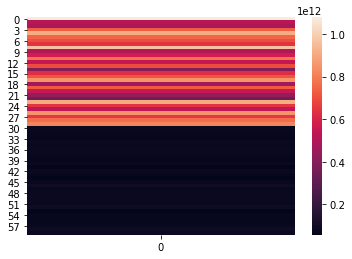

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(inf, device='cuda:0')
tensor(2.1358e+20, device='cuda:0')


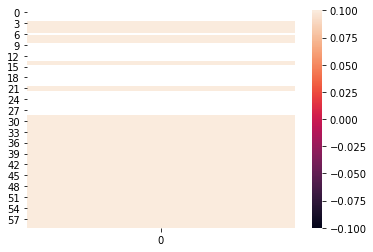

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(637395., device='cuda:0')
tensor(99885.0781, device='cuda:0')


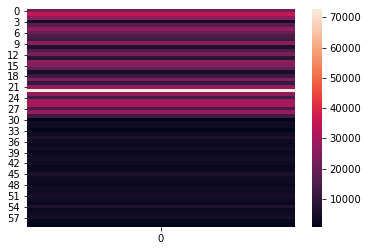

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(136188.5312, device='cuda:0')
tensor(48131.4570, device='cuda:0')


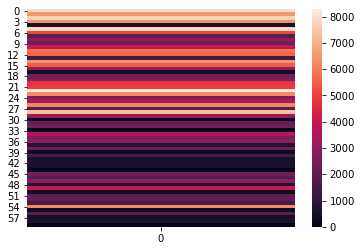

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(88057.0781, device='cuda:0')

**VAE_Gumbel_NInsta test here**

In [19]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [20]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.294006
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.674961
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.221031
Train Epoch: 1 [3840/8000 (48%)]	Loss: 39.730396
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.082882
Train Epoch: 1 [6400/8000 (80%)]	Loss: 38.695461
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.169300
====> Epoch: 1 Average loss: 39.6300
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.003162
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.516251
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.777893
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.157810
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.287170
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.275192
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.297264
====> Epoch: 2 Average loss: 36.0261
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.226944
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.083256
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.100769
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.873367
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.942493
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.282536
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.381838
====> Epoch: 22 Average loss: 31.2099
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.025547
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.291489
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.050579
Train Epoch: 23 [3840/8000 (48%)]	Loss: 30.966213
Train Epoch: 23 [5120/8000 (64%)]	Loss: 30.993820
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.017805
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.036785
====> Epoch: 23 Average loss: 31.1402
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.918943
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.320900
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.211248
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.059959
Train Epoch: 24 [5120/8000 (64%)]	Loss: 30.856218
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.227531
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.224648
====> Epoch: 24 Average loss: 31.0960
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.112539
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.36223

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.391024
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.638435
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.346529
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.761217
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.469156
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.778421
====> Epoch: 44 Average loss: 30.5884
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.483011
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.588219
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.309889
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.146250
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.647715
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.454983
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.327620
====> Epoch: 45 Average loss: 30.5869
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.521866
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.603550
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.565311
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.677940
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.583948
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.504795
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.165766
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.314869
====> Epoch: 65 Average loss: 30.4092
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.375870
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.395910
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.283554
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.771353
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.294895
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.121487
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.338730
====> Epoch: 66 Average loss: 30.4054
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.416710
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.591087
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.293823
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.406685
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.527002
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.261524
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.396797
====> Epoch: 67 Average loss: 30.3882
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.38037

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178507
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.046175
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.250492
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.332193
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.362762
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.891991
====> Epoch: 87 Average loss: 30.3031
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.182297
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.169449
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.114155
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.305826
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.077404
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.075031
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.232018
====> Epoch: 88 Average loss: 30.2972
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.257387
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.601273
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.366232
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.206963
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.453295
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.096375
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.470484
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.071169
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.323212
====> Epoch: 108 Average loss: 30.2730
Train Epoch: 109 [0/8000 (0%)]	Loss: 29.916391
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.356712
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.188297
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.205364
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.135725
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.342896
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.006624
====> Epoch: 109 Average loss: 30.2654
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.321934
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.168152
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.525772
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.619318
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.277552
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.594578
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.283054
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.300077
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.284035
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.272709
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.167391
====> Epoch: 129 Average loss: 30.2379
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.419777
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.234077
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.203911
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.392639
Train Epoch: 130 [5120/8000 (64%)]	Loss: 29.997576
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.049372
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.099876
====> Epoch: 130 Average loss: 30.2489
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.265560
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.282536
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.135750
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.171234
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.803310
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.277721
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091141
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.884279
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.851887
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.449347
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.058388
====> Epoch: 150 Average loss: 30.2107
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.360134
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.410763
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.515905
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.636078
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.428680
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.070696
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.312197
====> Epoch: 151 Average loss: 30.2140
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.043888
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.260092
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.433641
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.696085
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.505888
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.654621
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.448204
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.382788
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.348322
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.213768
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.093328
====> Epoch: 171 Average loss: 30.2098
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.419416
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.374466
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.560352
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.192398
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.718836
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.384720
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.365643
====> Epoch: 172 Average loss: 30.1942
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.342354
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.363396
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.923859
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.206079
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.238119
Train Epoch: 173 [6400/8000 (80%)]	Loss: 30.006392
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.031677
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.131165
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.166727
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.362795
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.088804
====> Epoch: 192 Average loss: 30.2174
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.000193
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.587288
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.289850
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.163725
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.369944
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.901571
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.363712
====> Epoch: 193 Average loss: 30.1870
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.007215
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.274511
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.058710
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.954018
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.089106
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.106995
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.161095
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.151472
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.430012
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.438835
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.664669
====> Epoch: 213 Average loss: 30.2313
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.115610
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.152273
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.545355
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.214430
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.416765
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.481083
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.650183
====> Epoch: 214 Average loss: 30.2039
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.464237
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.322521
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.698299
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.096378
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.242702
Train Epoch: 215 [6400/8000 (80%)]	Loss: 29.914900
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.248981
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.089245
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.026051
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.198946
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.062700
====> Epoch: 234 Average loss: 30.1913
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.408146
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.216909
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.922234
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.513023
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.387337
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.375715
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.271023
====> Epoch: 235 Average loss: 30.2091
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.152571
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.185419
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.069292
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.268948
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.933870
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.068043
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.040859
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.380520
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.070347
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.090445
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.184181
====> Epoch: 255 Average loss: 30.1943
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.159887
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.230589
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.920778
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.245010
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.940693
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.086391
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.161634
====> Epoch: 256 Average loss: 30.2055
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.491133
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.469748
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.407446
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.079481
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.994938
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.361095
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.972916
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.475616
Train Epoch: 276 [5120/8000 (64%)]	Loss: 29.919579
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.803923
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.224617
====> Epoch: 276 Average loss: 30.1819
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.076050
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.776440
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.430311
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.116207
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.936178
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.872826
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.453358
====> Epoch: 277 Average loss: 30.1931
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.105238
Train Epoch: 278 [1280/8000 (16%)]	Loss: 29.989845
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.199198
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.922333
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.197952
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.565453
Train Epoch: 278 [7680/8000 (96%)]	Loss: 29.864925
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.179266
Train Epoch: 297 [5120/8000 (64%)]	Loss: 30.111853
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.151140
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.060818
====> Epoch: 297 Average loss: 30.1663
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.275993
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.268492
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.984135
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.172707
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.364231
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.218153
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.609564
====> Epoch: 298 Average loss: 30.1779
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.041473
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.299482
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.195595
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.448664
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.196526
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.198639
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.287682
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 30.003923
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.297226
Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.289658
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.121279
====> Epoch: 318 Average loss: 30.1396
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.362047
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.360249
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.392157
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.043024
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.017567
Train Epoch: 319 [6400/8000 (80%)]	Loss: 29.989334
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.157738
====> Epoch: 319 Average loss: 30.1492
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.938625
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.286215
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.080505
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.348793
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.059395
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.182913
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.301086
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 30.182997
Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.089581
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.101091
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.220768
====> Epoch: 339 Average loss: 30.1223
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.139288
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.927477
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.779747
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.159437
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.806047
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.133924
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.092829
====> Epoch: 340 Average loss: 30.1070
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.256426
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.089981
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.358246
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125885
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.268991
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.330952
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.017445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.420675
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.766033
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.296032
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.230341
====> Epoch: 360 Average loss: 30.0845
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.345486
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.273596
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.993427
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.061996
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.131536
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.421658
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.105413
====> Epoch: 361 Average loss: 30.1014
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.072397
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.922609
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.309811
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.046808
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.126682
Train Epoch: 362 [6400/8000 (80%)]	Loss: 29.918795
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.074749
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.613770
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.724655
Train Epoch: 381 [6400/8000 (80%)]	Loss: 29.804926
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.961620
====> Epoch: 381 Average loss: 30.0623
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.183109
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.997011
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.902405
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.969408
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.207787
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.282871
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.998310
====> Epoch: 382 Average loss: 30.0512
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.269903
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.299252
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.171640
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.931541
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.629395
Train Epoch: 383 [6400/8000 (80%)]	Loss: 29.757893
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.963238
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.175789
Train Epoch: 402 [5120/8000 (64%)]	Loss: 29.887989
Train Epoch: 402 [6400/8000 (80%)]	Loss: 29.995186
Train Epoch: 402 [7680/8000 (96%)]	Loss: 29.969345
====> Epoch: 402 Average loss: 30.0551
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.010254
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.954784
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.040890
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.265469
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.322939
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.151382
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.137228
====> Epoch: 403 Average loss: 30.0447
Train Epoch: 404 [0/8000 (0%)]	Loss: 29.941679
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.045923
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.126509
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.178600
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.092436
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.893074
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921640
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.934706
Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.004772
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.037987
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.034168
====> Epoch: 423 Average loss: 29.9948
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.033138
Train Epoch: 424 [1280/8000 (16%)]	Loss: 29.767550
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.940527
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.218781
Train Epoch: 424 [5120/8000 (64%)]	Loss: 29.631599
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.001150
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.915234
====> Epoch: 424 Average loss: 30.0139
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.286678
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.213602
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.711617
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.979036
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.019054
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.868860
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.085268
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.783510
Train Epoch: 444 [5120/8000 (64%)]	Loss: 29.813013
Train Epoch: 444 [6400/8000 (80%)]	Loss: 29.951902
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.865713
====> Epoch: 444 Average loss: 29.9914
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.677734
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.274433
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.326160
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.068733
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.643242
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.815924
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.231411
====> Epoch: 445 Average loss: 29.9869
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.131243
Train Epoch: 446 [1280/8000 (16%)]	Loss: 29.837784
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.374887
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.875032
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.824734
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.213346
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.115992
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 30.051725
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.155891
Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.266390
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.112345
====> Epoch: 465 Average loss: 29.9813
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.215967
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.864027
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.917206
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.123886
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.753468
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.767427
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.833212
====> Epoch: 466 Average loss: 29.9587
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.881592
Train Epoch: 467 [1280/8000 (16%)]	Loss: 29.924387
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.012972
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.130840
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.124468
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.906775
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.990211
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.915602
Train Epoch: 486 [5120/8000 (64%)]	Loss: 29.973923
Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.091537
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.607044
====> Epoch: 486 Average loss: 29.9353
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.092516
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.088530
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.622282
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.337719
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.794832
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.543119
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.029179
====> Epoch: 487 Average loss: 29.9400
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.849018
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.028162
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.017376
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.102016
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.970299
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.745474
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.116478
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.571465
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.912592
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.438740
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.135162
====> Epoch: 507 Average loss: 29.9051
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.743870
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.831871
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.950203
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.760891
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.563946
Train Epoch: 508 [6400/8000 (80%)]	Loss: 29.741148
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.269218
====> Epoch: 508 Average loss: 29.9106
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.979746
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.707491
Train Epoch: 509 [2560/8000 (32%)]	Loss: 29.581871
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.130003
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.097424
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.559305
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.971350
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.987007
Train Epoch: 528 [5120/8000 (64%)]	Loss: 30.021584
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.919127
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.870325
====> Epoch: 528 Average loss: 29.8762
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.683046
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.778101
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.956152
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.714649
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.005371
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.844437
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.134241
====> Epoch: 529 Average loss: 29.8866
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.812834
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.274837
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.892214
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.981167
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.995932
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.917274
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.535563
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 30.085917
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.628534
Train Epoch: 549 [6400/8000 (80%)]	Loss: 30.060772
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.579880
====> Epoch: 549 Average loss: 29.8640
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.037004
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.857126
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.966520
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.920950
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.084209
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.467911
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.004768
====> Epoch: 550 Average loss: 29.8568
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.799965
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.171125
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.803900
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.744596
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.762976
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.187262
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.735924
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.927780
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.638351
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.814199
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.670891
====> Epoch: 570 Average loss: 29.8376
Train Epoch: 571 [0/8000 (0%)]	Loss: 30.067915
Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.012600
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.759165
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.905148
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.786507
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.082392
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.704580
====> Epoch: 571 Average loss: 29.8408
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.691250
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.544600
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.541388
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.849571
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.960392
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.471373
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.613537
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.750723
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.859995
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.822374
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.618015
====> Epoch: 591 Average loss: 29.8195
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.671484
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.769634
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.661835
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.839632
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.055424
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.674551
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.917309
====> Epoch: 592 Average loss: 29.8169
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.840458
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.667416
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.698488
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.796671
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.942127
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.985533
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.975321
====> Epoch:

tensor(1.4086e+11, device='cuda:0')
tensor(1.5905e+11, device='cuda:0')


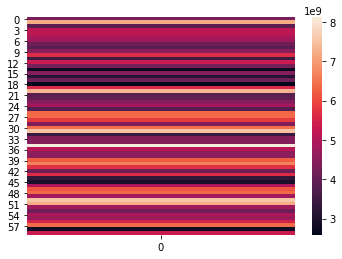

In [21]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(1.8779e+13, device='cuda:0')
tensor(2.2891e+13, device='cuda:0')


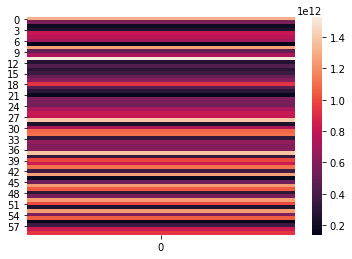

In [22]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(11040.6406, device='cuda:0')
tensor(479.3577, device='cuda:0')


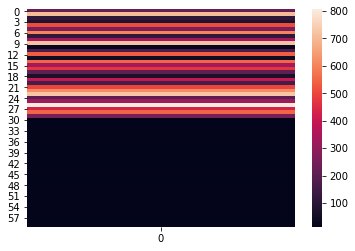

In [23]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2878.9263, device='cuda:0')
tensor(1.0740, device='cuda:0')


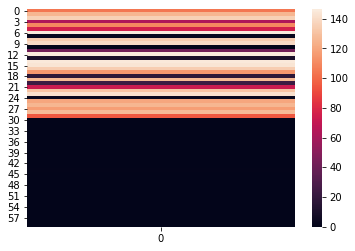

In [24]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [25]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2877.8523, device='cuda:0')

The new model


In [56]:
logits_changed_loss_lambda = 0.000
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = 0.90)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [57]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      logits_changed_loss_lambda = logits_changed_loss_lambda,
                                                      Dim = 2*D, 
                                                      DEBUG = True)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.984352
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.296581
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.665997
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.291683
Loss tensor(2547.7327, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5102.2451, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.723076
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.161663
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.662533
====> Epoch: 1 Average loss: 40.2121
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.342163
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.658878
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.258060
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.056351
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.529053
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.973099
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.540440
====> Epoch: 2 Average loss: 36.3303
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.473244
Loss tensor(2193.3201, device='cuda:0', grad_fn=<AddBackward0>)Log

Train Epoch: 14 [3840/8000 (48%)]	Loss: 32.601757
Train Epoch: 14 [5120/8000 (64%)]	Loss: 32.430714
Train Epoch: 14 [6400/8000 (80%)]	Loss: 32.247040
Loss tensor(2088.1309, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5625.9248, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 14 [7680/8000 (96%)]	Loss: 32.010193
====> Epoch: 14 Average loss: 32.5233
Train Epoch: 15 [0/8000 (0%)]	Loss: 32.852402
Train Epoch: 15 [1280/8000 (16%)]	Loss: 32.338013
Loss tensor(2070.2642, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6344.1377, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 15 [2560/8000 (32%)]	Loss: 32.413353
Loss tensor(2058.5273, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6476.3242, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 15 [3840/8000 (48%)]	Loss: 32.443146
Train Epoch: 15 [5120/8000 (64%)]	Loss: 32.613728
Train Epoch: 15 [6400/8000 (80%)]	Loss: 32.482735
Train Epoch: 15 [7680/8000 (96%)]	Loss: 32.173744
====>

Train Epoch: 29 [3840/8000 (48%)]	Loss: 31.363604
Train Epoch: 29 [5120/8000 (64%)]	Loss: 31.375319
Train Epoch: 29 [6400/8000 (80%)]	Loss: 31.087490
Train Epoch: 29 [7680/8000 (96%)]	Loss: 30.762594
====> Epoch: 29 Average loss: 31.2578
Train Epoch: 30 [0/8000 (0%)]	Loss: 31.107311
Train Epoch: 30 [1280/8000 (16%)]	Loss: 31.249544
Train Epoch: 30 [2560/8000 (32%)]	Loss: 31.358952
Train Epoch: 30 [3840/8000 (48%)]	Loss: 31.300716
Train Epoch: 30 [5120/8000 (64%)]	Loss: 31.113892
Train Epoch: 30 [6400/8000 (80%)]	Loss: 31.243093
Loss tensor(1998.8479, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5728.6650, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 30 [7680/8000 (96%)]	Loss: 31.617596
====> Epoch: 30 Average loss: 31.2011
Train Epoch: 31 [0/8000 (0%)]	Loss: 31.466291
Loss tensor(2011.0725, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6126.4541, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 31 [1280/8000 (16%)]	Loss: 31.109978
Train Ep

Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.639385
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.860353
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.871004
Train Epoch: 44 [7680/8000 (96%)]	Loss: 31.215982
====> Epoch: 44 Average loss: 30.9448
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.755323
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.997696
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.650938
Train Epoch: 45 [3840/8000 (48%)]	Loss: 31.038357
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.739517
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.707594
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.743589
====> Epoch: 45 Average loss: 30.9077
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.786356
Train Epoch: 46 [1280/8000 (16%)]	Loss: 31.136398
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.947233
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.584265
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.801233
Train Epoch: 46 [6400/8000 (80%)]	Loss: 30.904886
Train Epoch: 46 [7680/8000 (96%)]	Loss: 30.974274
====> Epoch: 46 Average loss: 30

Train Epoch: 60 [3840/8000 (48%)]	Loss: 31.124414
Train Epoch: 60 [5120/8000 (64%)]	Loss: 30.680422
Loss tensor(2010.5688, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5878.8633, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1971.3408, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6306.3936, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 60 [6400/8000 (80%)]	Loss: 30.691616
Train Epoch: 60 [7680/8000 (96%)]	Loss: 31.049343
====> Epoch: 60 Average loss: 30.8522
Train Epoch: 61 [0/8000 (0%)]	Loss: 30.853765
Train Epoch: 61 [1280/8000 (16%)]	Loss: 30.951345
Train Epoch: 61 [2560/8000 (32%)]	Loss: 30.873220
Train Epoch: 61 [3840/8000 (48%)]	Loss: 31.083857
Train Epoch: 61 [5120/8000 (64%)]	Loss: 31.167891
Train Epoch: 61 [6400/8000 (80%)]	Loss: 31.217682
Train Epoch: 61 [7680/8000 (96%)]	Loss: 30.470055
====> Epoch: 61 Average loss: 30.8461
Train Epoch: 62 [0/8000 (0%)]	Loss: 30.776117
Loss tensor(1960.9700, device='cuda:0', grad_fn=<AddBackwa

Train Epoch: 74 [2560/8000 (32%)]	Loss: 30.492254
Loss tensor(1956.5382, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5649.6851, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 74 [3840/8000 (48%)]	Loss: 30.694508
Train Epoch: 74 [5120/8000 (64%)]	Loss: 30.632053
Train Epoch: 74 [6400/8000 (80%)]	Loss: 30.623322
Train Epoch: 74 [7680/8000 (96%)]	Loss: 30.494017
====> Epoch: 74 Average loss: 30.7772
Train Epoch: 75 [0/8000 (0%)]	Loss: 30.788485
Loss tensor(1965.0682, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5352.8701, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 75 [1280/8000 (16%)]	Loss: 30.732525
Train Epoch: 75 [2560/8000 (32%)]	Loss: 30.867020
Train Epoch: 75 [3840/8000 (48%)]	Loss: 30.843006
Train Epoch: 75 [5120/8000 (64%)]	Loss: 30.409876
Train Epoch: 75 [6400/8000 (80%)]	Loss: 30.855906
Loss tensor(1975.4425, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5080.2612, device='cuda:0', grad_fn=<MseLossBackward>)
Train

Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.384504
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.757133
Loss tensor(1962.6687, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6140.6680, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.489187
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.998682
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.615973
Train Epoch: 88 [7680/8000 (96%)]	Loss: 31.331419
====> Epoch: 88 Average loss: 30.7134
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.574980
Loss tensor(1946.7694, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6007.5342, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.878448
Loss tensor(1975.0131, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6779.7017, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.906271
Loss tensor(1948.7820, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6124.4272, device='cuda

Train Epoch: 105 [1280/8000 (16%)]	Loss: 30.919634
Train Epoch: 105 [2560/8000 (32%)]	Loss: 30.787468
Train Epoch: 105 [3840/8000 (48%)]	Loss: 30.955849
Train Epoch: 105 [5120/8000 (64%)]	Loss: 30.948740
Train Epoch: 105 [6400/8000 (80%)]	Loss: 30.818386
Loss tensor(1966.5016, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5867.0278, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 105 [7680/8000 (96%)]	Loss: 30.681555
====> Epoch: 105 Average loss: 30.7248
Train Epoch: 106 [0/8000 (0%)]	Loss: 30.726736
Train Epoch: 106 [1280/8000 (16%)]	Loss: 30.950985
Train Epoch: 106 [2560/8000 (32%)]	Loss: 30.486752
Train Epoch: 106 [3840/8000 (48%)]	Loss: 30.885523
Train Epoch: 106 [5120/8000 (64%)]	Loss: 31.127106
Train Epoch: 106 [6400/8000 (80%)]	Loss: 30.755196
Train Epoch: 106 [7680/8000 (96%)]	Loss: 30.845423
====> Epoch: 106 Average loss: 30.7651
Train Epoch: 107 [0/8000 (0%)]	Loss: 30.568146
Train Epoch: 107 [1280/8000 (16%)]	Loss: 31.085133
Train Epoch: 107 [2560/8000 

Train Epoch: 120 [6400/8000 (80%)]	Loss: 30.828115
Train Epoch: 120 [7680/8000 (96%)]	Loss: 30.663380
====> Epoch: 120 Average loss: 30.7125
Train Epoch: 121 [0/8000 (0%)]	Loss: 30.403002
Train Epoch: 121 [1280/8000 (16%)]	Loss: 30.922167
Train Epoch: 121 [2560/8000 (32%)]	Loss: 30.944021
Loss tensor(1971.0735, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5214.2344, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 121 [3840/8000 (48%)]	Loss: 30.604528
Train Epoch: 121 [5120/8000 (64%)]	Loss: 30.776758
Train Epoch: 121 [6400/8000 (80%)]	Loss: 30.294693
Loss tensor(1956.6764, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5482.6445, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 121 [7680/8000 (96%)]	Loss: 30.495699
====> Epoch: 121 Average loss: 30.7340
Train Epoch: 122 [0/8000 (0%)]	Loss: 30.686817
Loss tensor(1982.2158, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5853.7891, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epo

Train Epoch: 135 [2560/8000 (32%)]	Loss: 30.655270
Train Epoch: 135 [3840/8000 (48%)]	Loss: 30.782526
Loss tensor(1968.5653, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5696.2100, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 135 [5120/8000 (64%)]	Loss: 30.704395
Train Epoch: 135 [6400/8000 (80%)]	Loss: 30.599119
Train Epoch: 135 [7680/8000 (96%)]	Loss: 30.951742
====> Epoch: 135 Average loss: 30.7321
Train Epoch: 136 [0/8000 (0%)]	Loss: 30.688744
Train Epoch: 136 [1280/8000 (16%)]	Loss: 30.874393
Train Epoch: 136 [2560/8000 (32%)]	Loss: 30.603924
Train Epoch: 136 [3840/8000 (48%)]	Loss: 30.830189
Train Epoch: 136 [5120/8000 (64%)]	Loss: 30.935722
Train Epoch: 136 [6400/8000 (80%)]	Loss: 30.640133
Train Epoch: 136 [7680/8000 (96%)]	Loss: 30.840446
====> Epoch: 136 Average loss: 30.7074
Train Epoch: 137 [0/8000 (0%)]	Loss: 31.078974
Train Epoch: 137 [1280/8000 (16%)]	Loss: 30.774054
Train Epoch: 137 [2560/8000 (32%)]	Loss: 30.572109
Train Epoch: 137 [3840/8000 

Train Epoch: 151 [1280/8000 (16%)]	Loss: 31.021460
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.485586
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.700752
Train Epoch: 151 [5120/8000 (64%)]	Loss: 31.509964
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.851490
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.602486
====> Epoch: 151 Average loss: 30.8048
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.436443
Train Epoch: 152 [1280/8000 (16%)]	Loss: 31.701656
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.762077
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.526724
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.422907
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.437817
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.599882
====> Epoch: 152 Average loss: 30.7660
Train Epoch: 153 [0/8000 (0%)]	Loss: 30.514236
Train Epoch: 153 [1280/8000 (16%)]	Loss: 30.556858
Train Epoch: 153 [2560/8000 (32%)]	Loss: 30.751400
Train Epoch: 153 [3840/8000 (48%)]	Loss: 30.628941
Train Epoch: 153 [5120/8000 (64%)]	Loss: 30.656940
Loss tensor(

Train Epoch: 165 [3840/8000 (48%)]	Loss: 30.869473
Loss tensor(1957.1807, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5409.3652, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 165 [5120/8000 (64%)]	Loss: 30.887678
Train Epoch: 165 [6400/8000 (80%)]	Loss: 30.851778
Train Epoch: 165 [7680/8000 (96%)]	Loss: 31.294657
====> Epoch: 165 Average loss: 30.7869
Train Epoch: 166 [0/8000 (0%)]	Loss: 30.823938
Train Epoch: 166 [1280/8000 (16%)]	Loss: 30.967634
Train Epoch: 166 [2560/8000 (32%)]	Loss: 30.675695
Train Epoch: 166 [3840/8000 (48%)]	Loss: 30.935284
Train Epoch: 166 [5120/8000 (64%)]	Loss: 30.772020
Train Epoch: 166 [6400/8000 (80%)]	Loss: 31.125515
Train Epoch: 166 [7680/8000 (96%)]	Loss: 30.431894
====> Epoch: 166 Average loss: 30.8138
Train Epoch: 167 [0/8000 (0%)]	Loss: 30.435518
Train Epoch: 167 [1280/8000 (16%)]	Loss: 31.271549
Train Epoch: 167 [2560/8000 (32%)]	Loss: 30.648537
Train Epoch: 167 [3840/8000 (48%)]	Loss: 30.973560
Train Epoch: 167 [5120/8000 

Train Epoch: 180 [6400/8000 (80%)]	Loss: 30.959398
Train Epoch: 180 [7680/8000 (96%)]	Loss: 30.835743
====> Epoch: 180 Average loss: 30.8428
Train Epoch: 181 [0/8000 (0%)]	Loss: 30.938929
Train Epoch: 181 [1280/8000 (16%)]	Loss: 30.935947
Train Epoch: 181 [2560/8000 (32%)]	Loss: 30.420599
Train Epoch: 181 [3840/8000 (48%)]	Loss: 30.847702
Train Epoch: 181 [5120/8000 (64%)]	Loss: 30.863756
Train Epoch: 181 [6400/8000 (80%)]	Loss: 30.521870
Train Epoch: 181 [7680/8000 (96%)]	Loss: 30.516432
====> Epoch: 181 Average loss: 30.7943
Train Epoch: 182 [0/8000 (0%)]	Loss: 30.390923
Loss tensor(1939.0741, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5367.2021, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 182 [1280/8000 (16%)]	Loss: 30.830198
Train Epoch: 182 [2560/8000 (32%)]	Loss: 30.820881
Loss tensor(1996.7976, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5408.0898, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 182 [3840/8000 (48%)]	Loss: 30.

Train Epoch: 196 [1280/8000 (16%)]	Loss: 31.137581
Train Epoch: 196 [2560/8000 (32%)]	Loss: 30.732903
Train Epoch: 196 [3840/8000 (48%)]	Loss: 30.900084
Loss tensor(1970.3004, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5513.5957, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 196 [5120/8000 (64%)]	Loss: 30.875257
Train Epoch: 196 [6400/8000 (80%)]	Loss: 30.458843
Train Epoch: 196 [7680/8000 (96%)]	Loss: 30.722668
====> Epoch: 196 Average loss: 30.8483
Train Epoch: 197 [0/8000 (0%)]	Loss: 30.774639
Train Epoch: 197 [1280/8000 (16%)]	Loss: 30.659788
Train Epoch: 197 [2560/8000 (32%)]	Loss: 30.709009
Train Epoch: 197 [3840/8000 (48%)]	Loss: 30.993904
Train Epoch: 197 [5120/8000 (64%)]	Loss: 30.469011
Train Epoch: 197 [6400/8000 (80%)]	Loss: 30.743874
Train Epoch: 197 [7680/8000 (96%)]	Loss: 31.127453
====> Epoch: 197 Average loss: 30.8374
Train Epoch: 198 [0/8000 (0%)]	Loss: 31.414259
Train Epoch: 198 [1280/8000 (16%)]	Loss: 30.758066
Train Epoch: 198 [2560/8000 

Train Epoch: 212 [1280/8000 (16%)]	Loss: 30.873659
Loss tensor(1954.1110, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5917.0088, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 212 [2560/8000 (32%)]	Loss: 31.100376
Train Epoch: 212 [3840/8000 (48%)]	Loss: 30.672104
Train Epoch: 212 [5120/8000 (64%)]	Loss: 31.013105
Train Epoch: 212 [6400/8000 (80%)]	Loss: 30.953268
Loss tensor(2000.7698, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5162.8438, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 212 [7680/8000 (96%)]	Loss: 30.760258
Loss tensor(1964.2711, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5252.0518, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 212 Average loss: 30.8658
Train Epoch: 213 [0/8000 (0%)]	Loss: 30.532698
Train Epoch: 213 [1280/8000 (16%)]	Loss: 30.688734
Loss tensor(1988.0186, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5571.6567, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tens

Train Epoch: 227 [6400/8000 (80%)]	Loss: 30.499514
Train Epoch: 227 [7680/8000 (96%)]	Loss: 30.612801
====> Epoch: 227 Average loss: 30.8525
Train Epoch: 228 [0/8000 (0%)]	Loss: 30.444487
Train Epoch: 228 [1280/8000 (16%)]	Loss: 31.149847
Train Epoch: 228 [2560/8000 (32%)]	Loss: 30.636662
Train Epoch: 228 [3840/8000 (48%)]	Loss: 30.923182
Train Epoch: 228 [5120/8000 (64%)]	Loss: 30.954407
Train Epoch: 228 [6400/8000 (80%)]	Loss: 31.239956
Train Epoch: 228 [7680/8000 (96%)]	Loss: 30.837608
====> Epoch: 228 Average loss: 30.8049
Train Epoch: 229 [0/8000 (0%)]	Loss: 30.854309
Train Epoch: 229 [1280/8000 (16%)]	Loss: 30.394760
Train Epoch: 229 [2560/8000 (32%)]	Loss: 31.017303
Loss tensor(1955.1876, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5831.6768, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 229 [3840/8000 (48%)]	Loss: 30.686754
Train Epoch: 229 [5120/8000 (64%)]	Loss: 31.130234
Train Epoch: 229 [6400/8000 (80%)]	Loss: 30.947895
Train Epoch: 229 [7680/8000 

Train Epoch: 242 [6400/8000 (80%)]	Loss: 30.622280
Train Epoch: 242 [7680/8000 (96%)]	Loss: 30.648869
====> Epoch: 242 Average loss: 30.8449
Train Epoch: 243 [0/8000 (0%)]	Loss: 30.837372
Train Epoch: 243 [1280/8000 (16%)]	Loss: 30.733013
Train Epoch: 243 [2560/8000 (32%)]	Loss: 31.253300
Train Epoch: 243 [3840/8000 (48%)]	Loss: 31.250149
Loss tensor(1956.1523, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5343.5400, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 243 [5120/8000 (64%)]	Loss: 30.925095
Train Epoch: 243 [6400/8000 (80%)]	Loss: 30.187513
Train Epoch: 243 [7680/8000 (96%)]	Loss: 30.906002
====> Epoch: 243 Average loss: 30.8778
Train Epoch: 244 [0/8000 (0%)]	Loss: 30.522455
Train Epoch: 244 [1280/8000 (16%)]	Loss: 30.660210
Train Epoch: 244 [2560/8000 (32%)]	Loss: 30.740192
Loss tensor(1967.2172, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5741.6470, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 244 [3840/8000 (48%)]	Loss: 30.

Train Epoch: 255 [1280/8000 (16%)]	Loss: 30.888073
Train Epoch: 255 [2560/8000 (32%)]	Loss: 31.137596
Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.472509
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.972446
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.743511
Train Epoch: 255 [7680/8000 (96%)]	Loss: 31.347097
====> Epoch: 255 Average loss: 30.8906
Train Epoch: 256 [0/8000 (0%)]	Loss: 31.371723
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.855194
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.791449
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.450283
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.611403
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.738155
Loss tensor(1944.7207, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5790.2158, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.533731
====> Epoch: 256 Average loss: 30.8712
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.886200
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.618151
Train Epoch: 257 [2560/8000 

Train Epoch: 269 [3840/8000 (48%)]	Loss: 30.925055
Train Epoch: 269 [5120/8000 (64%)]	Loss: 30.818056
Train Epoch: 269 [6400/8000 (80%)]	Loss: 30.661457
Train Epoch: 269 [7680/8000 (96%)]	Loss: 30.387392
====> Epoch: 269 Average loss: 30.8862
Train Epoch: 270 [0/8000 (0%)]	Loss: 30.984142
Train Epoch: 270 [1280/8000 (16%)]	Loss: 31.536064
Train Epoch: 270 [2560/8000 (32%)]	Loss: 31.392551
Train Epoch: 270 [3840/8000 (48%)]	Loss: 30.921768
Loss tensor(2004.1621, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5429.4619, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 270 [5120/8000 (64%)]	Loss: 30.834057
Train Epoch: 270 [6400/8000 (80%)]	Loss: 30.562260
Loss tensor(1969.8643, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5629.3179, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 270 [7680/8000 (96%)]	Loss: 30.726948
====> Epoch: 270 Average loss: 30.8665
Train Epoch: 271 [0/8000 (0%)]	Loss: 31.157694
Train Epoch: 271 [1280/8000 (16%)]	Loss: 30.

Train Epoch: 283 [2560/8000 (32%)]	Loss: 31.307398
Loss tensor(2014.3208, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5852.7266, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 283 [3840/8000 (48%)]	Loss: 31.026718
Train Epoch: 283 [5120/8000 (64%)]	Loss: 30.607035
Train Epoch: 283 [6400/8000 (80%)]	Loss: 30.849335
Loss tensor(1955.5958, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5662.6611, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 283 [7680/8000 (96%)]	Loss: 30.785971
====> Epoch: 283 Average loss: 30.8868
Train Epoch: 284 [0/8000 (0%)]	Loss: 30.898121
Train Epoch: 284 [1280/8000 (16%)]	Loss: 31.035238
Train Epoch: 284 [2560/8000 (32%)]	Loss: 31.325827
Train Epoch: 284 [3840/8000 (48%)]	Loss: 30.701641
Train Epoch: 284 [5120/8000 (64%)]	Loss: 32.079372
Train Epoch: 284 [6400/8000 (80%)]	Loss: 30.935955
Train Epoch: 284 [7680/8000 (96%)]	Loss: 30.781258
====> Epoch: 284 Average loss: 30.9286
Train Epoch: 285 [0/8000 (0%)]	Loss: 31.

Train Epoch: 298 [6400/8000 (80%)]	Loss: 31.024282
Train Epoch: 298 [7680/8000 (96%)]	Loss: 31.088745
====> Epoch: 298 Average loss: 30.9054
Train Epoch: 299 [0/8000 (0%)]	Loss: 32.168274
Train Epoch: 299 [1280/8000 (16%)]	Loss: 31.613834
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.633711
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.591410
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.909702
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.914055
Loss tensor(1967.6984, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5498.0752, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.455648
====> Epoch: 299 Average loss: 30.9697
Train Epoch: 300 [0/8000 (0%)]	Loss: 30.869314
Train Epoch: 300 [1280/8000 (16%)]	Loss: 31.125923
Train Epoch: 300 [2560/8000 (32%)]	Loss: 31.112587
Train Epoch: 300 [3840/8000 (48%)]	Loss: 30.728020
Train Epoch: 300 [5120/8000 (64%)]	Loss: 30.933355
Train Epoch: 300 [6400/8000 (80%)]	Loss: 30.572208
Train Epoch: 300 [7680/8000 

Train Epoch: 313 [2560/8000 (32%)]	Loss: 30.537201
Train Epoch: 313 [3840/8000 (48%)]	Loss: 30.615934
Train Epoch: 313 [5120/8000 (64%)]	Loss: 30.980717
Train Epoch: 313 [6400/8000 (80%)]	Loss: 30.880873
Train Epoch: 313 [7680/8000 (96%)]	Loss: 31.151180
====> Epoch: 313 Average loss: 30.8491
Train Epoch: 314 [0/8000 (0%)]	Loss: 31.029051
Train Epoch: 314 [1280/8000 (16%)]	Loss: 30.779947
Loss tensor(1956.4760, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5243.8042, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1974.7051, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5903.9976, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 314 [2560/8000 (32%)]	Loss: 30.695881
Loss tensor(1961.8005, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6564.9663, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 314 [3840/8000 (48%)]	Loss: 30.909794
Train Epoch: 314 [5120/8000 (64%)]	Loss: 30.593407
Train Epoch: 314 [6400/8000 (80%)]	Loss: 31.

Train Epoch: 327 [2560/8000 (32%)]	Loss: 30.334515
Train Epoch: 327 [3840/8000 (48%)]	Loss: 31.019640
Train Epoch: 327 [5120/8000 (64%)]	Loss: 30.840700
Train Epoch: 327 [6400/8000 (80%)]	Loss: 30.707148
Train Epoch: 327 [7680/8000 (96%)]	Loss: 31.191126
====> Epoch: 327 Average loss: 30.9117
Train Epoch: 328 [0/8000 (0%)]	Loss: 30.975719
Train Epoch: 328 [1280/8000 (16%)]	Loss: 30.922972
Train Epoch: 328 [2560/8000 (32%)]	Loss: 30.581184
Train Epoch: 328 [3840/8000 (48%)]	Loss: 31.359953
Train Epoch: 328 [5120/8000 (64%)]	Loss: 30.771162
Train Epoch: 328 [6400/8000 (80%)]	Loss: 30.733158
Train Epoch: 328 [7680/8000 (96%)]	Loss: 30.772705
====> Epoch: 328 Average loss: 30.8787
Train Epoch: 329 [0/8000 (0%)]	Loss: 30.493059
Train Epoch: 329 [1280/8000 (16%)]	Loss: 30.811266
Train Epoch: 329 [2560/8000 (32%)]	Loss: 31.060568
Train Epoch: 329 [3840/8000 (48%)]	Loss: 30.527275
Train Epoch: 329 [5120/8000 (64%)]	Loss: 31.538067
Train Epoch: 329 [6400/8000 (80%)]	Loss: 30.963303
Train Epoch:

Train Epoch: 343 [3840/8000 (48%)]	Loss: 31.520790
Train Epoch: 343 [5120/8000 (64%)]	Loss: 30.747051
Train Epoch: 343 [6400/8000 (80%)]	Loss: 30.654047
Train Epoch: 343 [7680/8000 (96%)]	Loss: 30.943468
====> Epoch: 343 Average loss: 30.9395
Train Epoch: 344 [0/8000 (0%)]	Loss: 30.678745
Train Epoch: 344 [1280/8000 (16%)]	Loss: 30.530508
Train Epoch: 344 [2560/8000 (32%)]	Loss: 30.356709
Train Epoch: 344 [3840/8000 (48%)]	Loss: 30.589109
Train Epoch: 344 [5120/8000 (64%)]	Loss: 30.886995
Loss tensor(1954.2162, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5306.8457, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 344 [6400/8000 (80%)]	Loss: 31.524757
Train Epoch: 344 [7680/8000 (96%)]	Loss: 30.895151
====> Epoch: 344 Average loss: 30.9532
Train Epoch: 345 [0/8000 (0%)]	Loss: 30.515627
Train Epoch: 345 [1280/8000 (16%)]	Loss: 30.860800
Train Epoch: 345 [2560/8000 (32%)]	Loss: 31.850903
Train Epoch: 345 [3840/8000 (48%)]	Loss: 31.362623
Train Epoch: 345 [5120/8000 

Train Epoch: 357 [1280/8000 (16%)]	Loss: 30.515905
Train Epoch: 357 [2560/8000 (32%)]	Loss: 30.484175
Train Epoch: 357 [3840/8000 (48%)]	Loss: 30.754166
Loss tensor(1979.2524, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5524.8281, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 357 [5120/8000 (64%)]	Loss: 30.910213
Train Epoch: 357 [6400/8000 (80%)]	Loss: 31.106153
Train Epoch: 357 [7680/8000 (96%)]	Loss: 30.660549
====> Epoch: 357 Average loss: 30.9406
Train Epoch: 358 [0/8000 (0%)]	Loss: 30.574812
Train Epoch: 358 [1280/8000 (16%)]	Loss: 31.250357
Train Epoch: 358 [2560/8000 (32%)]	Loss: 31.001888
Train Epoch: 358 [3840/8000 (48%)]	Loss: 30.648687
Train Epoch: 358 [5120/8000 (64%)]	Loss: 30.849661
Train Epoch: 358 [6400/8000 (80%)]	Loss: 30.959167
Loss tensor(2012.6315, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6705.4424, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 358 [7680/8000 (96%)]	Loss: 30.896729
====> Epoch: 358 Average los

Train Epoch: 373 [2560/8000 (32%)]	Loss: 30.715336
Train Epoch: 373 [3840/8000 (48%)]	Loss: 30.917002
Train Epoch: 373 [5120/8000 (64%)]	Loss: 30.983044
Loss tensor(1987.0961, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5629.8037, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 373 [6400/8000 (80%)]	Loss: 31.472061
Train Epoch: 373 [7680/8000 (96%)]	Loss: 31.190796
====> Epoch: 373 Average loss: 30.8740
Train Epoch: 374 [0/8000 (0%)]	Loss: 31.478102
Train Epoch: 374 [1280/8000 (16%)]	Loss: 31.907970
Train Epoch: 374 [2560/8000 (32%)]	Loss: 30.348154
Loss tensor(1982.9963, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5757.1816, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 374 [3840/8000 (48%)]	Loss: 30.618086
Train Epoch: 374 [5120/8000 (64%)]	Loss: 30.509912
Train Epoch: 374 [6400/8000 (80%)]	Loss: 30.696257
Train Epoch: 374 [7680/8000 (96%)]	Loss: 30.808064
====> Epoch: 374 Average loss: 30.9245
Train Epoch: 375 [0/8000 (0%)]	Loss: 30.

Train Epoch: 388 [6400/8000 (80%)]	Loss: 31.701748
Loss tensor(1997.4564, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(6356.8633, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 388 [7680/8000 (96%)]	Loss: 31.490852
====> Epoch: 388 Average loss: 30.8639
Train Epoch: 389 [0/8000 (0%)]	Loss: 31.668470
Train Epoch: 389 [1280/8000 (16%)]	Loss: 30.681110
Train Epoch: 389 [2560/8000 (32%)]	Loss: 30.955622
Train Epoch: 389 [3840/8000 (48%)]	Loss: 32.100517
Train Epoch: 389 [5120/8000 (64%)]	Loss: 31.328098
Train Epoch: 389 [6400/8000 (80%)]	Loss: 30.987528
Train Epoch: 389 [7680/8000 (96%)]	Loss: 30.776100
====> Epoch: 389 Average loss: 30.8380
Train Epoch: 390 [0/8000 (0%)]	Loss: 30.643219
Train Epoch: 390 [1280/8000 (16%)]	Loss: 30.639854
Train Epoch: 390 [2560/8000 (32%)]	Loss: 30.492472
Train Epoch: 390 [3840/8000 (48%)]	Loss: 30.865044
Train Epoch: 390 [5120/8000 (64%)]	Loss: 30.726309
Loss tensor(2000.3800, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tens

Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.774099
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.361654
Loss tensor(1984.9189, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5350.3374, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.765165
Train Epoch: 404 [7680/8000 (96%)]	Loss: 30.961287
====> Epoch: 404 Average loss: 30.9071
Train Epoch: 405 [0/8000 (0%)]	Loss: 30.755699
Train Epoch: 405 [1280/8000 (16%)]	Loss: 30.865595
Train Epoch: 405 [2560/8000 (32%)]	Loss: 30.791298
Train Epoch: 405 [3840/8000 (48%)]	Loss: 30.868086
Train Epoch: 405 [5120/8000 (64%)]	Loss: 30.952787
Train Epoch: 405 [6400/8000 (80%)]	Loss: 31.144484
Train Epoch: 405 [7680/8000 (96%)]	Loss: 31.070189
====> Epoch: 405 Average loss: 30.9248
Train Epoch: 406 [0/8000 (0%)]	Loss: 30.796490
Train Epoch: 406 [1280/8000 (16%)]	Loss: 31.022919
Train Epoch: 406 [2560/8000 (32%)]	Loss: 30.790524
Train Epoch: 406 [3840/8000 (48%)]	Loss: 30.545492
Train Epoch: 406 [5120/8000 

Loss tensor(1986.9653, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(7491.3423, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 419 [1280/8000 (16%)]	Loss: 31.063272
Train Epoch: 419 [2560/8000 (32%)]	Loss: 30.753576
Train Epoch: 419 [3840/8000 (48%)]	Loss: 31.217346
Train Epoch: 419 [5120/8000 (64%)]	Loss: 30.862066
Train Epoch: 419 [6400/8000 (80%)]	Loss: 30.360762
Train Epoch: 419 [7680/8000 (96%)]	Loss: 30.587877
====> Epoch: 419 Average loss: 30.8626
Train Epoch: 420 [0/8000 (0%)]	Loss: 30.879133
Train Epoch: 420 [1280/8000 (16%)]	Loss: 30.102655
Train Epoch: 420 [2560/8000 (32%)]	Loss: 30.854509
Train Epoch: 420 [3840/8000 (48%)]	Loss: 30.707787
Train Epoch: 420 [5120/8000 (64%)]	Loss: 30.835487
Train Epoch: 420 [6400/8000 (80%)]	Loss: 31.504179
Train Epoch: 420 [7680/8000 (96%)]	Loss: 30.693058
====> Epoch: 420 Average loss: 30.9079
Train Epoch: 421 [0/8000 (0%)]	Loss: 31.177929
Train Epoch: 421 [1280/8000 (16%)]	Loss: 30.455215
Train Epoch: 421 [2560/8000 

Train Epoch: 433 [7680/8000 (96%)]	Loss: 30.953194
====> Epoch: 433 Average loss: 30.8625
Train Epoch: 434 [0/8000 (0%)]	Loss: 31.525734
Train Epoch: 434 [1280/8000 (16%)]	Loss: 31.410015
Train Epoch: 434 [2560/8000 (32%)]	Loss: 30.850605
Train Epoch: 434 [3840/8000 (48%)]	Loss: 30.191427
Train Epoch: 434 [5120/8000 (64%)]	Loss: 30.907366
Train Epoch: 434 [6400/8000 (80%)]	Loss: 30.878868
Loss tensor(1994.1113, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(9477.5479, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 434 [7680/8000 (96%)]	Loss: 30.844259
====> Epoch: 434 Average loss: 30.8060
Train Epoch: 435 [0/8000 (0%)]	Loss: 30.687397
Train Epoch: 435 [1280/8000 (16%)]	Loss: 30.851089
Train Epoch: 435 [2560/8000 (32%)]	Loss: 30.316034
Train Epoch: 435 [3840/8000 (48%)]	Loss: 31.607777
Train Epoch: 435 [5120/8000 (64%)]	Loss: 31.255829
Train Epoch: 435 [6400/8000 (80%)]	Loss: 30.894258
Train Epoch: 435 [7680/8000 (96%)]	Loss: 30.385950
====> Epoch: 435 Average los

Train Epoch: 448 [3840/8000 (48%)]	Loss: 31.082077
Train Epoch: 448 [5120/8000 (64%)]	Loss: 31.148350
Train Epoch: 448 [6400/8000 (80%)]	Loss: 30.525799
Train Epoch: 448 [7680/8000 (96%)]	Loss: 30.210436
====> Epoch: 448 Average loss: 30.8496
Train Epoch: 449 [0/8000 (0%)]	Loss: 30.828768
Train Epoch: 449 [1280/8000 (16%)]	Loss: 31.400793
Train Epoch: 449 [2560/8000 (32%)]	Loss: 31.510397
Train Epoch: 449 [3840/8000 (48%)]	Loss: 30.751839
Loss tensor(1979.6204, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(18570.4883, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 449 [5120/8000 (64%)]	Loss: 31.770969
Loss tensor(1953.9744, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(15233.3730, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 449 [6400/8000 (80%)]	Loss: 30.436661
Train Epoch: 449 [7680/8000 (96%)]	Loss: 30.623316
====> Epoch: 449 Average loss: 30.8508
Train Epoch: 450 [0/8000 (0%)]	Loss: 30.391247
Train Epoch: 450 [1280/8000 (16%)]	Loss: 3

Train Epoch: 463 [1280/8000 (16%)]	Loss: 30.639881
Train Epoch: 463 [2560/8000 (32%)]	Loss: 30.714899
Train Epoch: 463 [3840/8000 (48%)]	Loss: 30.441940
Train Epoch: 463 [5120/8000 (64%)]	Loss: 30.409277
Train Epoch: 463 [6400/8000 (80%)]	Loss: 30.449612
Loss tensor(1958.2791, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(9828.6094, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 463 [7680/8000 (96%)]	Loss: 30.803143
====> Epoch: 463 Average loss: 30.8670
Train Epoch: 464 [0/8000 (0%)]	Loss: 30.640526
Loss tensor(1956.2682, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(8056.8208, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 464 [1280/8000 (16%)]	Loss: 30.520292
Train Epoch: 464 [2560/8000 (32%)]	Loss: 31.011492
Train Epoch: 464 [3840/8000 (48%)]	Loss: 30.628828
Loss tensor(1950.8644, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(8876.3691, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 464 [5120/8000 (64%)]	Loss: 31.

Train Epoch: 476 [1280/8000 (16%)]	Loss: 30.919252
Loss tensor(1971.2755, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(9731.3477, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 476 [2560/8000 (32%)]	Loss: 30.672434
Train Epoch: 476 [3840/8000 (48%)]	Loss: 30.771126
Train Epoch: 476 [5120/8000 (64%)]	Loss: 30.779661
Train Epoch: 476 [6400/8000 (80%)]	Loss: 31.497692
Train Epoch: 476 [7680/8000 (96%)]	Loss: 30.400663
====> Epoch: 476 Average loss: 30.8388
Train Epoch: 477 [0/8000 (0%)]	Loss: 31.952221
Train Epoch: 477 [1280/8000 (16%)]	Loss: 30.867369
Train Epoch: 477 [2560/8000 (32%)]	Loss: 30.831476
Train Epoch: 477 [3840/8000 (48%)]	Loss: 30.545237
Train Epoch: 477 [5120/8000 (64%)]	Loss: 30.693552
Train Epoch: 477 [6400/8000 (80%)]	Loss: 30.479212
Train Epoch: 477 [7680/8000 (96%)]	Loss: 30.953835
====> Epoch: 477 Average loss: 30.8661
Train Epoch: 478 [0/8000 (0%)]	Loss: 30.664059
Train Epoch: 478 [1280/8000 (16%)]	Loss: 30.727716
Train Epoch: 478 [2560/8000 

Train Epoch: 492 [1280/8000 (16%)]	Loss: 31.208094
Train Epoch: 492 [2560/8000 (32%)]	Loss: 30.920019
Train Epoch: 492 [3840/8000 (48%)]	Loss: 30.739058
Loss tensor(1979.5490, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 492 [5120/8000 (64%)]	Loss: 31.283522
Train Epoch: 492 [6400/8000 (80%)]	Loss: 30.637062
Train Epoch: 492 [7680/8000 (96%)]	Loss: 31.515329
====> Epoch: 492 Average loss: 30.9633
Train Epoch: 493 [0/8000 (0%)]	Loss: 30.420843
Train Epoch: 493 [1280/8000 (16%)]	Loss: 30.462790
Loss tensor(2000.1642, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 493 [2560/8000 (32%)]	Loss: 31.098969
Train Epoch: 493 [3840/8000 (48%)]	Loss: 30.530102
Train Epoch: 493 [5120/8000 (64%)]	Loss: 30.914459
Train Epoch: 493 [6400/8000 (80%)]	Loss: 31.033890
Train Epoch: 493 [7680/8000 (96%)]	Loss: 30.580610
====> Epoch: 493 Average loss: 30.9412
Train Epoch: 494 [0/8000 (0%)]	Loss: 31.633249
Train Epoch: 494 [1280/8000 (16%)]	Loss: 30.462250
Train Epoch

Loss tensor(1990.1239, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.870785
====> Epoch: 507 Average loss: 31.0790
Train Epoch: 508 [0/8000 (0%)]	Loss: 31.283863
Train Epoch: 508 [1280/8000 (16%)]	Loss: 31.117897
Train Epoch: 508 [2560/8000 (32%)]	Loss: 30.745636
Loss tensor(1988.4246, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 508 [3840/8000 (48%)]	Loss: 30.930698
Train Epoch: 508 [5120/8000 (64%)]	Loss: 30.777481
Train Epoch: 508 [6400/8000 (80%)]	Loss: 31.451780
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.822084
====> Epoch: 508 Average loss: 31.1858
Train Epoch: 509 [0/8000 (0%)]	Loss: 31.406790
Loss tensor(1991.9431, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 509 [1280/8000 (16%)]	Loss: 30.600002
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.793236
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.957745
Train Epoch: 509 [5120/8000 (64%)]	Loss: 31.126369
Train Epoch: 509 [6400/8000 (80%)]	L

Train Epoch: 524 [3840/8000 (48%)]	Loss: 30.745388
Train Epoch: 524 [5120/8000 (64%)]	Loss: 31.182980
Train Epoch: 524 [6400/8000 (80%)]	Loss: 31.511423
Train Epoch: 524 [7680/8000 (96%)]	Loss: 30.765123
====> Epoch: 524 Average loss: 31.0136
Train Epoch: 525 [0/8000 (0%)]	Loss: 32.093014
Train Epoch: 525 [1280/8000 (16%)]	Loss: 30.597233
Train Epoch: 525 [2560/8000 (32%)]	Loss: 31.026222
Train Epoch: 525 [3840/8000 (48%)]	Loss: 31.134375
Train Epoch: 525 [5120/8000 (64%)]	Loss: 31.161831
Loss tensor(2026.6589, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 525 [6400/8000 (80%)]	Loss: 30.494659
Train Epoch: 525 [7680/8000 (96%)]	Loss: 30.750946
====> Epoch: 525 Average loss: 31.0415
Train Epoch: 526 [0/8000 (0%)]	Loss: 31.056499
Train Epoch: 526 [1280/8000 (16%)]	Loss: 30.753080
Train Epoch: 526 [2560/8000 (32%)]	Loss: 31.135139
Train Epoch: 526 [3840/8000 (48%)]	Loss: 30.640045
Loss tensor(1984.6621, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Loss tensor

Train Epoch: 541 [1280/8000 (16%)]	Loss: 31.011265
Train Epoch: 541 [2560/8000 (32%)]	Loss: 31.192001
Train Epoch: 541 [3840/8000 (48%)]	Loss: 30.921265
Loss tensor(2067.2798, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 541 [5120/8000 (64%)]	Loss: 31.903708
Train Epoch: 541 [6400/8000 (80%)]	Loss: 31.015280
Train Epoch: 541 [7680/8000 (96%)]	Loss: 30.585283
====> Epoch: 541 Average loss: 31.1137
Train Epoch: 542 [0/8000 (0%)]	Loss: 30.930593
Loss tensor(2007.1232, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 542 [1280/8000 (16%)]	Loss: 30.521643
Loss tensor(1985.6553, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 542 [2560/8000 (32%)]	Loss: 31.052820
Loss tensor(1931.1975, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 542 [3840/8000 (48%)]	Loss: 30.808857
Train Epoch: 542 [5120/8000 (64%)]	Loss: 30.433298
Train Epoch: 542 [6400/8000 (80%)]	Loss: 31.210793
Train Epoch: 542 [7680/8000 (96%)]	Loss: 31.7

Train Epoch: 558 [1280/8000 (16%)]	Loss: 30.781078
Train Epoch: 558 [2560/8000 (32%)]	Loss: 30.494324
Train Epoch: 558 [3840/8000 (48%)]	Loss: 31.026831
Train Epoch: 558 [5120/8000 (64%)]	Loss: 31.033651
Loss tensor(2006.6571, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 558 [6400/8000 (80%)]	Loss: 31.505650
Train Epoch: 558 [7680/8000 (96%)]	Loss: 30.652821
====> Epoch: 558 Average loss: 30.9238
Train Epoch: 559 [0/8000 (0%)]	Loss: 30.409010
Train Epoch: 559 [1280/8000 (16%)]	Loss: 31.368759
Loss tensor(1980.5294, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 559 [2560/8000 (32%)]	Loss: 31.113428
Train Epoch: 559 [3840/8000 (48%)]	Loss: 30.821516
Train Epoch: 559 [5120/8000 (64%)]	Loss: 30.650309
Train Epoch: 559 [6400/8000 (80%)]	Loss: 31.404404
Loss tensor(1970.1105, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 559 [7680/8000 (96%)]	Loss: 31.472820
====> Epoch: 559 Average loss: 31.0603
Train Epoch: 560 [0/8000 (0%)]	L

Train Epoch: 575 [3840/8000 (48%)]	Loss: 31.709431
Train Epoch: 575 [5120/8000 (64%)]	Loss: 31.115355
Train Epoch: 575 [6400/8000 (80%)]	Loss: 30.299198
Train Epoch: 575 [7680/8000 (96%)]	Loss: 31.681705
====> Epoch: 575 Average loss: 31.0638
Train Epoch: 576 [0/8000 (0%)]	Loss: 30.808001
Loss tensor(1991.6844, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 576 [1280/8000 (16%)]	Loss: 31.120070
Train Epoch: 576 [2560/8000 (32%)]	Loss: 30.893156
Train Epoch: 576 [3840/8000 (48%)]	Loss: 31.346420
Train Epoch: 576 [5120/8000 (64%)]	Loss: 30.579250
Train Epoch: 576 [6400/8000 (80%)]	Loss: 30.669531
Train Epoch: 576 [7680/8000 (96%)]	Loss: 31.593353
====> Epoch: 576 Average loss: 31.0889
Train Epoch: 577 [0/8000 (0%)]	Loss: 30.565716
Train Epoch: 577 [1280/8000 (16%)]	Loss: 30.764820
Train Epoch: 577 [2560/8000 (32%)]	Loss: 31.605659
Train Epoch: 577 [3840/8000 (48%)]	Loss: 31.911819
Loss tensor(2017.7540, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch

Train Epoch: 592 [3840/8000 (48%)]	Loss: 31.194016
Loss tensor(1969.8378, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.839725
Train Epoch: 592 [6400/8000 (80%)]	Loss: 30.801468
Loss tensor(1955.2471, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Loss tensor(2056.0696, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.650993
====> Epoch: 592 Average loss: 31.0444
Train Epoch: 593 [0/8000 (0%)]	Loss: 30.728285
Loss tensor(1983.0878, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 593 [1280/8000 (16%)]	Loss: 31.020365
Train Epoch: 593 [2560/8000 (32%)]	Loss: 31.049078
Loss tensor(1960.9214, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 593 [3840/8000 (48%)]	Loss: 31.800661
Loss tensor(1949.0874, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 593 [5120/8000 (64%)]	Loss: 30.862053
Loss tensor(1972.2478, device='cuda:0', grad

tensor(2191070.5000, device='cuda:0')
tensor(122137.7266, device='cuda:0')


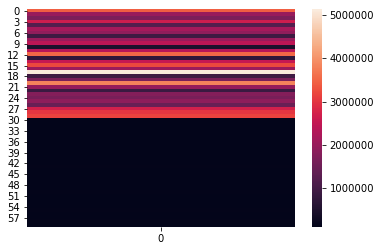

In [58]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(724363.3750, device='cuda:0')
tensor(32161.6973, device='cuda:0')


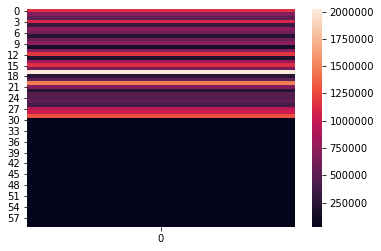

In [59]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(5774.1182, device='cuda:0')
tensor(5745.8809, device='cuda:0')


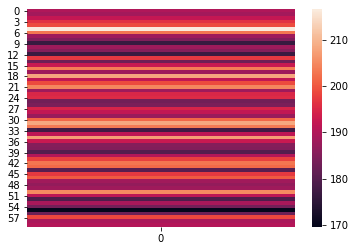

In [60]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1434.9473, device='cuda:0')
tensor(1445.0527, device='cuda:0')


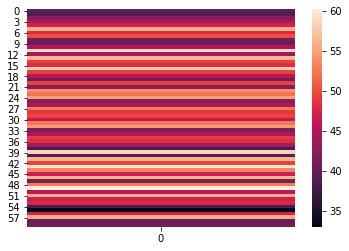

In [61]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [62]:
subset_indices_post_burnin[:(D)]

tensor([39.7688, 38.7418, 42.2763, 44.4588, 47.1731, 56.0627, 47.8921, 50.1419,
        40.9997, 40.4059, 44.9652, 58.8390, 44.0834, 56.5485, 49.2926, 48.0476,
        58.0637, 49.4793, 45.4781, 41.0874, 49.3352, 42.5077, 54.2084, 52.2616,
        54.9602, 42.1194, 44.6025, 52.7440, 48.7812, 49.6212], device='cuda:0')

In [63]:
subset_indices_post_burnin[(D):]

tensor([46.0998, 52.5229, 54.6648, 41.5718, 44.4620, 49.0775, 48.2831, 43.9144,
        38.3871, 58.5036, 39.1723, 56.1636, 49.5634, 59.8092, 53.2929, 46.8111,
        56.2912, 41.8532, 52.7542, 60.2053, 45.6606, 56.2259, 46.8382, 47.6888,
        38.3156, 32.9659, 47.4376, 55.7158, 40.0151, 40.7859], device='cuda:0')

In [64]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(-10.1055, device='cuda:0')

In [65]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [66]:
sum(top_ind < 30)

tensor(11, device='cuda:0')

In [67]:
sum(top_ind >= 30)

tensor(13, device='cuda:0')